<a href="https://colab.research.google.com/github/Thujaina/NIT-Internship/blob/main/binary_CE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install imblearn

In [2]:
!pip install seaborn

In [3]:
!pip install -U tensorflow scikeras imbalanced-learn

In [4]:
!pip install scikeras

In [5]:
!pip install -U scikit-learn scikeras


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from keras.losses import BinaryCrossentropy

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, matthews_corrcoef

from imblearn.over_sampling import SMOTE
from scikeras.wrappers import KerasClassifier

import warnings
warnings.filterwarnings("ignore")


In [7]:
from google.colab import drive
drive.mount("/content/drive")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
TRAIN_PATH = "/content/drive/MyDrive/datasets/ECG/mitbih_train.csv"
TEST_PATH  = "/content/drive/MyDrive/datasets/ECG/mitbih_test.csv"

train = pd.read_csv(TRAIN_PATH, header=None)
test  = pd.read_csv(TEST_PATH, header=None)

print("Train shape:", train.shape)
print("Test shape:", test.shape)


Train shape: (87554, 188)
Test shape: (21892, 188)


In [9]:
X_train = train.iloc[:, :-1]
y_train = train.iloc[:, -1]

X_test = test.iloc[:, :-1]
y_test = test.iloc[:, -1]


In [10]:
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)


In [11]:
# Required for Binary Cross-Entropy with multiple sigmoid outputs
y_res_cat  = to_categorical(y_res, num_classes=5)
y_test_cat = to_categorical(y_test, num_classes=5)


In [12]:
X_train, X_val, y_train, y_val = train_test_split(
    X_res, y_res_cat, test_size=0.2, random_state=0
)


In [13]:
loss_fn = BinaryCrossentropy()


In [14]:
def ann_model():
    model = Sequential([
        Dense(128, activation="relu", input_shape=(X_train.shape[1],)),
        Dense(64, activation="relu"),
        Dense(5, activation="sigmoid")  # IMPORTANT
    ])

    model.compile(
        optimizer="adam",
        loss=loss_fn,
        metrics=["accuracy"]
    )

    return model


In [15]:
model = ann_model()

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=64
)


Epoch 1/10
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.8250 - loss: 0.1728 - val_accuracy: 0.9434 - val_loss: 0.0638
Epoch 2/10
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.9494 - loss: 0.0574 - val_accuracy: 0.9639 - val_loss: 0.0428
Epoch 3/10
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.9671 - loss: 0.0400 - val_accuracy: 0.9697 - val_loss: 0.0364
Epoch 4/10
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.9740 - loss: 0.0322 - val_accuracy: 0.9798 - val_loss: 0.0258
Epoch 5/10
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.9797 - loss: 0.0260 - val_accuracy: 0.9828 - val_loss: 0.0225
Epoch 6/10
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.9828 - loss: 0.0229 - val_accuracy: 0.9847 - val_loss: 0.0199
Epoch 7/10
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.9849 - loss: 0.0199 - val_accuracy: 0.9857 - val_loss: 0.0193
Epoch 8/10
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.9871 - loss: 0

In [16]:
y_val_pred = (model.predict(X_val) > 0.5).astype(int)
y_val_true = y_val.astype(int)

mcc = matthews_corrcoef(
    y_val_true.argmax(axis=1),
    y_val_pred.argmax(axis=1)
)

print("Validation MCC:", mcc)


2265/2265 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
Validation MCC: 0.9815197855696854


In [17]:
test_predictions = (model.predict(X_test) > 0.5).astype(int)
test_loss, test_acc = model.evaluate(X_test, y_test_cat)

print("Test Accuracy:", test_acc)
print("Test Loss:", test_loss)


685/685 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
685/685 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9729 - loss: 0.0400
Test Accuracy: 0.9677507877349854
Test Loss: 0.05428299680352211


In [18]:
print(
    classification_report(
        y_test_cat.argmax(axis=1),
        test_predictions.argmax(axis=1)
    )
)


              precision    recall  f1-score   support

           0       0.99      0.98      0.99     18118
           1       0.64      0.81      0.71       556
           2       0.95      0.93      0.94      1448
           3       0.76      0.80      0.78       162
           4       0.97      0.97      0.97      1608

    accuracy                           0.97     21892
   macro avg       0.86      0.90      0.88     21892
weighted avg       0.97      0.97      0.97     21892



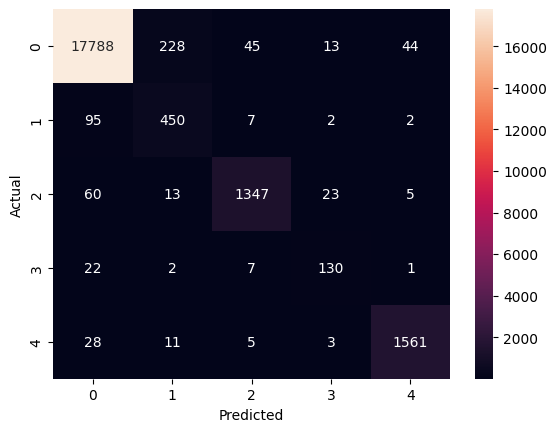

In [19]:
cm = confusion_matrix(
    y_test_cat.argmax(axis=1),
    test_predictions.argmax(axis=1)
)

sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [20]:
estimator = KerasClassifier(
    model=ann_model,
    epochs=10,
    batch_size=64,
    verbose=0
)

kfold = KFold(n_splits=4, shuffle=True, random_state=42)

results = cross_val_score(
    estimator,
    X_res,
    y_res_cat,
    cv=kfold,
    scoring="accuracy"
)

print("Cross-validation scores:", results)
print("Mean CV accuracy:", results.mean())


Cross-validation scores: [0.98931438 0.98904944 0.98866308 0.98721685]
Mean CV accuracy: 0.9885609379087139
